### Условие:

Обучаемся на данных train.csv, а валидируемся на test.csv.

Необходимо обучить нейронную сеть определять цифру на изображении по заданному вектору.

### Решение

In [149]:
import pandas as pd
import numpy as np

In [150]:
df_train = pd.read_csv('./data/hw6/train.csv')
df_test = pd.read_csv('./data/hw6/test.csv')

In [151]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
df_train.iloc[:,1:].to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [153]:
import matplotlib.pyplot as plt
import torch

In [154]:
t = int(df_train.shape[0] * 0.7) # 70% - в обучающую выборку, остальное на тест

my_trainset = []
my_testset = []

for index, row in df_train.iterrows():
    ser = row[1:] * 1/256 - 0.5 # нормализация
    ten = torch.from_numpy(ser.to_numpy().reshape((1,28, 28)))
    ten = ten.float()
    val = (ten , row[0])
    if index < t:
        my_trainset.append(val)
    else:
        my_testset.append(val)


In [166]:
unlabledset = []
for index, row in df_test.iterrows():
    ser = row[0:] * 1/256 - 0.5 # нормализация
    ten = torch.from_numpy(ser.to_numpy().reshape((1,28, 28)))
    ten = ten.float()
    val = (ten , None)
    unlabledset.append(val)

Каждое изображение имеет размер torch.Size([1, 28, 28])


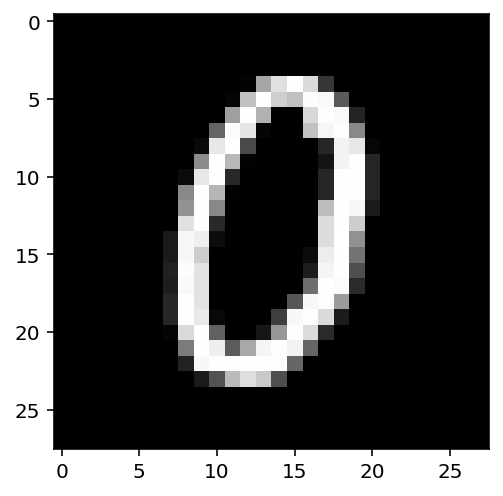

In [155]:
# Изобразим элемент выборки
image, labels = my_trainset[5]
print(f'Каждое изображение имеет размер {image.shape}')
plt.imshow(image.numpy().squeeze(), cmap = 'Greys_r')

In [156]:
trainloader = torch.utils.data.DataLoader(my_trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(my_testset, batch_size = 64, shuffle = True)

In [157]:
# Простейшая трехслойная модель с использованием сверточных слоев
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(3,3)),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(3,3), stride=(1,1)),
    torch.nn.Dropout(0.2),
    torch.nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(4, 4)),
    torch.nn.Dropout(0.2),
    torch.nn.Flatten(),
    torch.nn.LogSoftmax(dim = 1)
)

In [158]:
# Опередение функции потерь
criterion = torch.nn.NLLLoss()

# Определение оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

# Количество эпох, используемое для обучения
epochs = 15

train_losses, test_losses = [], []

In [159]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Если доступна видеокарта, то обучение на ней быстрее
model = model.to(device) # При обучении на гпу модель должна храниться на гпу

In [160]:
model.train()
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Очищаем градиенты с прошлого шага
        optimizer.zero_grad()

        output = model.forward(images.to(device))
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()
    
        running_loss += loss.cpu().item()
    else:
        test_loss = 0
        accuracy = 0
    
        # На валидации не нужно считать градиенты
        with torch.no_grad():
      
            model.eval()
      
            # Считаем значение функции потерь и точность на валидационной выборке
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device)).cpu().item()
                # Преобразование в вероятности и подсчет точности 
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class.cpu() == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
              "Test loss: {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15.. Training loss: 0.685.. Test loss: 0.139.. Test Accuracy: 0.959
Epoch: 2/15.. Training loss: 0.364.. Test loss: 0.102.. Test Accuracy: 0.971
Epoch: 3/15.. Training loss: 0.326.. Test loss: 0.071.. Test Accuracy: 0.979
Epoch: 4/15.. Training loss: 0.307.. Test loss: 0.063.. Test Accuracy: 0.980
Epoch: 5/15.. Training loss: 0.301.. Test loss: 0.060.. Test Accuracy: 0.982
Epoch: 6/15.. Training loss: 0.285.. Test loss: 0.059.. Test Accuracy: 0.984
Epoch: 7/15.. Training loss: 0.276.. Test loss: 0.052.. Test Accuracy: 0.984
Epoch: 8/15.. Training loss: 0.278.. Test loss: 0.072.. Test Accuracy: 0.979
Epoch: 9/15.. Training loss: 0.268.. Test loss: 0.048.. Test Accuracy: 0.985
Epoch: 10/15.. Training loss: 0.268.. Test loss: 0.052.. Test Accuracy: 0.985
Epoch: 11/15.. Training loss: 0.263.. Test loss: 0.055.. Test Accuracy: 0.985
Epoch: 12/15.. Training loss: 0.266.. Test loss: 0.051.. Test Accuracy: 0.986
Epoch: 13/15.. Training loss: 0.251.. Test loss: 0.050.. Test Accuracy: 0

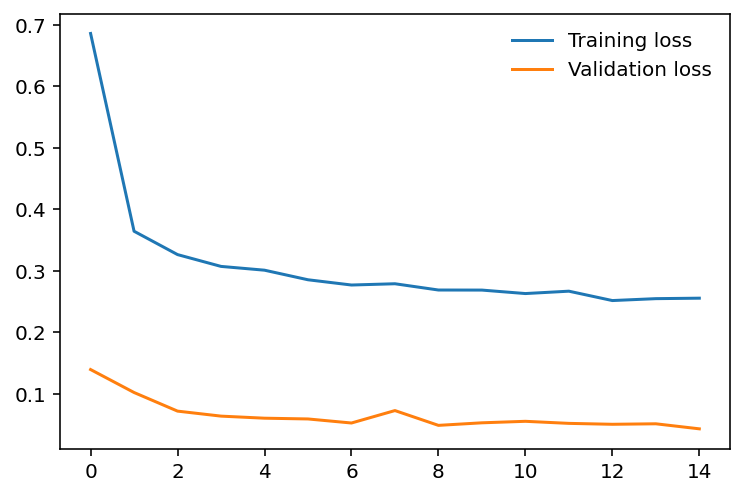

In [161]:
# Построение графика значений функции потерь на обучающей и тестовой выборках в зависимости от эпохи

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [162]:
# Функция для визуализации
def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['0',
                            '1',
                            '2',
                            '3',
                            '4',
                            '5',
                            '6',
                            '7',
                            '8',
                            '9'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

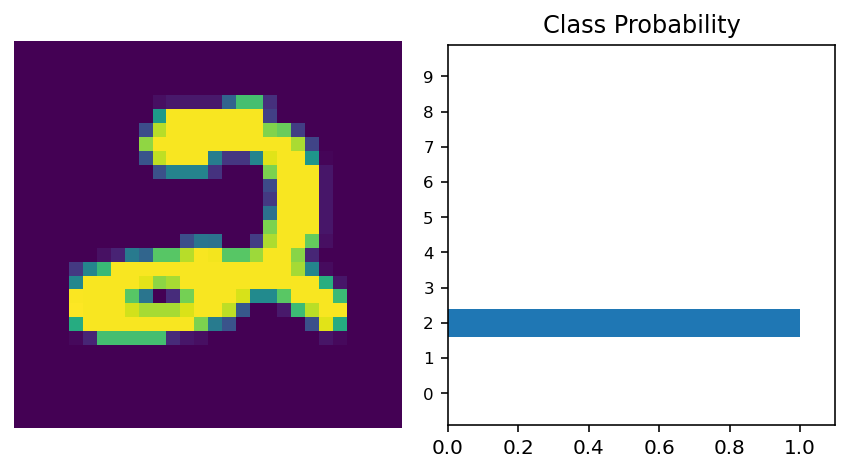

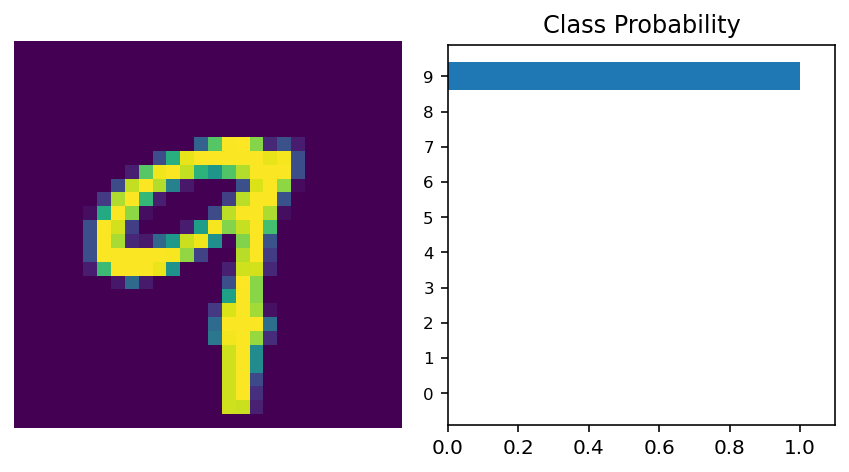

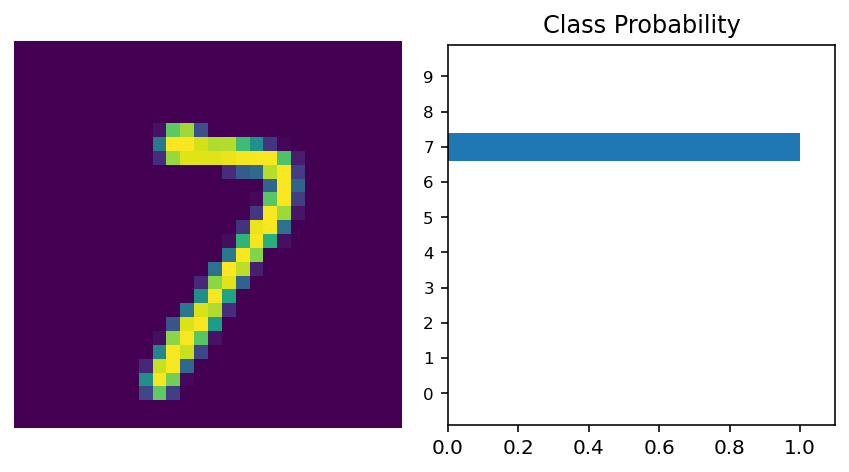

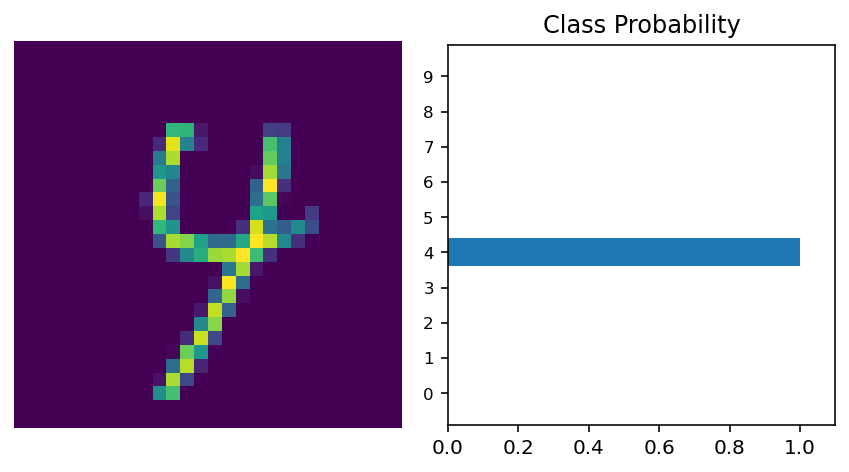

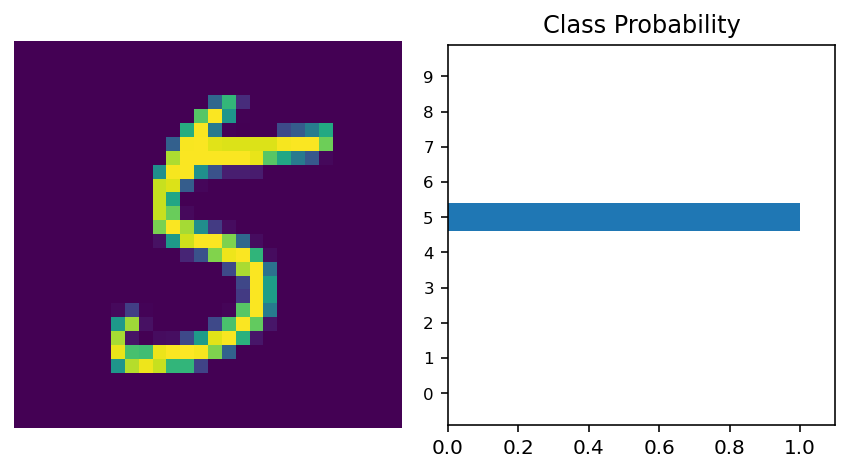

In [170]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Выбираем картинку из немаркированного набора данных
# img, label = my_trainset[8]

for i in range(0,100,20):
    img, label = unlabledset[i]
    model.eval()
    with torch.no_grad():
        # Вычисляем вероятности
        ps = torch.exp(model(img.to(device).unsqueeze(0))).cpu()

    
    # Построение верооятностного распределения
    view_classify(img, ps, version='Fashion')